## Исследовательский анализ данных в Python и проверка гипотез для сервиса Яндекс Афиша

## Цели и задачи проекта

**Цель проекта** - найти причину изменения пользовательского спроса и выяснить, отличается ли поведение клиентов, пользующихся мобильными устройствами и станционарными компьютерами.

**Задачи:**
- провести исследовательский анализ данных;
- проверить гипотезы команды аналитики с помощью статистических методов;
- сформулировать общий вывод по полученным результатам;
- дать рекомендации для бизнеса на основе проведенного анализа.

## Содержание проекта

1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ
4. Статистический анализ

##  Загрузка данных и знакомство с ними

Загрузим данные из файлов, оценим их объем и корректность.

In [ ]:
# Загружаем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import seaborn as sns
import numpy as np

In [ ]:
# Сохраняем файлы в датафреймы
orders_df = pd.read_csv('/datasets/final_tickets_orders_df.csv')
events_df = pd.read_csv('/datasets/final_tickets_events_df.csv')
tenge_df = pd.read_csv('/datasets/final_tickets_tenge_df.csv')

In [ ]:
# Выводим первые строки датафрейма orders_df и информацию о нем
display(orders_df.info(),orders_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

None

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


Датасет `orders_df` содержит 14 столбцов, пропуски есть только в столбце `days_since_prev`, что не является ошибкой. Типы данных определены не совсем верно, их можно поменять: 
- Столбцы `order_id` и `event_id` выражены типом `int64`, хотя нет смысла совершать с ними какие-либо математические преобразования, поэтому следует поменять тип на `object`.
- Столбцы `created_dt_msk` и  `created_ts_msk` содержат даты, поэтому нужно перевести их в формат `datetime64`.
- В столбцах `age_limit`, `tickets_count` и `total` можно оптимизировать размерность типов данных `int64` и `float64`.

In [ ]:
# Выводим первые строки датафрейма events_df и информацию о нем
display(events_df.info(),events_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


None

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


Датасет `events_df` содержит 11 столбцов, пропусков нет ни в одном из них. Типы данных определены не совсем верно, их можно поменять:

- Столбцы `event_id` выражены типом `int64`, хотя нет смысла совершать с ними какие-либо математические преобразования, поэтому следует поменять тип на `object`.
- В столбцах `city_id` и `venue_id` можно оптимизировать размерность типов данных `int64`.

In [ ]:
# Выводим первые строки датафрейма tenge_df и информацию о нем
display(tenge_df.info(),tenge_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


None

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


Датасет `tenge_df` содержит 4 столбца, пропуски отсутствуют. Типы данных определены не совсем верно, их можно поменять:
- Столбец `data` содержит дату, но выражен типом `object`, что является некорректным. Следует перевести его в тип `datetime64`.
- В столбцах `nominal` и `curs` можно оптимизировать размерность типов данных `int64` и `float64`.

В целом данные соответствуют названиям столбцов, являются полными и корректными, за исключением неверного распределения типов данных. 

## Предобработка данных

### Проверка значений в категориальных столбцах

Посмотрим какие значения содержат столбцы с категориальными данными и проверим есть ли среди них значения, которые могут обозначать пропуски в данных или отсутствие информации.

In [ ]:
def check_unique_values(df, columns):
    for col in columns:
        print(f"Уникальные значения в столбце '{col}':")
        print(df[col].nunique(), "уникальных значений")
        display(df[col].unique())
        print("\n")

category_columns = ['cinema_circuit', 'currency_code', 'device_type_canonical','service_name']
events_cat_columns = [
    'event_name',
    'event_type_description',
    'event_type_main',
    'organizers',
    'region_name', 
    'city_name',
    'venue_name',
    'venue_address'
]

# Приводим значения к строковому формату, удаляем пробелы и приводим к нижнему регистру
for col in category_columns:
    orders_df[col] = orders_df[col].astype(str).str.strip().str.lower()

for col in events_cat_columns:
    events_df[col] = events_df[col].astype(str).str.strip().str.lower()

# Проверяем уникальные значения
check_unique_values(orders_df, category_columns)
check_unique_values(events_df, events_cat_columns)

Уникальные значения в столбце 'cinema_circuit':
6 уникальных значений


array(['нет', 'другое', 'киномакс', 'киносити', 'москино', 'центрфильм'],
      dtype=object)



Уникальные значения в столбце 'currency_code':
2 уникальных значений


array(['rub', 'kzt'], dtype=object)



Уникальные значения в столбце 'device_type_canonical':
2 уникальных значений


array(['mobile', 'desktop'], dtype=object)



Уникальные значения в столбце 'service_name':
36 уникальных значений


array(['край билетов', 'мой билет', 'за билетом!', 'лови билет!',
       'билеты без проблем', 'облачко', 'лучшие билеты', 'прачечная',
       'быстробилет', 'дом культуры', 'весь в билетах', 'билеты в руки',
       'тебе билет!', 'show_ticket', 'городской дом культуры', 'яблоко',
       'билет по телефону', 'выступления.ру', 'росбилет',
       'шоу начинается!', 'мир касс', 'восьмёрка', 'телебилет',
       'crazy ticket!', 'реестр', 'быстрый кассир', 'карандашру',
       'радио ticket', 'дырокол', 'вперёд!', 'кино билет', 'цвет и билет',
       'зе бест!', 'тех билет', 'лимоны', 'билеты в интернете'],
      dtype=object)



Уникальные значения в столбце 'event_name':
15248 уникальных значений


array(['e4f26fba-da77-4c61-928a-6c3e434d793f',
       '5cc08a60-fdea-4186-9bb2-bffc3603fb77',
       '8e379a89-3a10-4811-ba06-ec22ebebe989', ...,
       '196f51a8-344a-462a-b806-a8467fd0e5fa',
       '9283cb32-2750-43cd-b57e-dde9ccd5552e',
       'f4952452-27ff-4d03-9adb-f7836430f83b'], dtype=object)



Уникальные значения в столбце 'event_type_description':
20 уникальных значений


array(['спектакль', 'балет', 'мюзикл', 'опера', 'концерт', 'шоу', 'ёлка',
       'цирковое шоу', 'событие', 'фестиваль', 'спортивное мероприятие',
       'выставка', 'спорт', 'оперетта', 'экскурсия', 'рок-мюзикл',
       'музыкальный спектакль', 'снегурочка', 'подарок',
       'кукольный спектакль'], dtype=object)



Уникальные значения в столбце 'event_type_main':
7 уникальных значений


array(['театр', 'концерты', 'ёлки', 'другое', 'стендап', 'выставки',
       'спорт'], dtype=object)



Уникальные значения в столбце 'organizers':
4293 уникальных значений


array(['№4893', '№1931', '№4896', ..., '№4817', '№5105', '№4552'],
      dtype=object)



Уникальные значения в столбце 'region_name':
81 уникальных значений


array(['североярская область', 'светополянский округ',
       'каменевский регион', 'лесодальний край', 'медовская область',
       'широковская область', 'тепляковская область', 'травяная область',
       'зоринский регион', 'серебринская область', 'яблоневская область',
       'глиногорская область', 'речиновская область', 'озернинский край',
       'горицветская область', 'солнечнореченская область',
       'травиницкий округ', 'солнечноземская область',
       'ключеводский округ', 'островная область', 'луговая область',
       'каменноозёрный край', 'лесостепной край', 'зеленоградский округ',
       'поленовский край', 'лугоградская область', 'синегорский регион',
       'малиновая область', 'речицкая область', 'дальнеземская область',
       'заречная область', 'североозёрский округ', 'дальнезорский край',
       'малиновоярский округ', 'сосновская область',
       'златопольский округ', 'ягодиновская область',
       'берестовский округ', 'золотоключевской край',
       'каменно



Уникальные значения в столбце 'city_name':
352 уникальных значений


array(['озёрск', 'глиноград', 'глиногорск', 'родниковец', 'радужсвет',
       'радужнополье', 'горнодолинск', 'родниковск', 'луговинск',
       'озёрчане', 'светополье', 'теплоозеро', 'дальнесветск', 'лесоярич',
       'островецк', 'озёрово', 'сосновечин', 'ягодиновка', 'родниковецк',
       'глинополье', 'акбасты', 'лесоводск', 'синеводов', 'ордакент',
       'крутовинск', 'шаныртау', 'дальнозолотск', 'кристалевск',
       'вишнёво', 'тихоярск', 'сарыжар', 'радужанов', 'теплоозёрск',
       'каменевский', 'островополь', 'кенесар', 'рощино', 'верховино',
       'сосновогорец', 'дальнозерск', 'солчелуг', 'дальнополин', 'кумсай',
       'каменосветск', 'речинцево', 'светогория', 'поленоозёрово',
       'поляногорье', 'дальнесоснов', 'заречиновка', 'радужнояр',
       'каменский', 'речевинец', 'ордасай', 'песковино', 'медовецк',
       'акбастау', 'луговаярово', 'травяниново', 'каражол', 'глиногорь',
       'дальнесветин', 'горнополец', 'травогород', 'серебрянка',
       'сосноград', 'мал



Уникальные значения в столбце 'venue_name':
3217 уникальных значений


array(['кладбище искусств "проблема" и партнеры',
       'лекции по искусству "свет" групп', 'кинокомитет "золотая" инк',
       ..., 'эстрадный театр "вытяжка" лимитед',
       'школа композиции "окно" лимитед',
       'клуб современных танцев "кофе" групп'], dtype=object)



Уникальные значения в столбце 'venue_address':
3225 уникальных значений


array(['наб. загородная, д. 785', 'ул. ягодная, д. 942',
       'ш. коммуны, д. 92 стр. 6', ..., 'ул. гаражная, д. 7 к. 32',
       'алл. есенина, д. 5/8 к. 2', 'ш. тупиковое, д. 49 стр. 73'],
      dtype=object)

В целом, категориальные значения представлены корректно и не содержат значений, которые могут обозначать пропуски.

### Проверка значений в количественных столбцах

Посмотрим на распределение значений в столбце `revenue` для рублей и тенге.

In [ ]:
# Используем метод describe для нахождения выбросов
orders_df[orders_df['currency_code']=='rub']['revenue'].describe()

count    285780.000000
mean        547.568333
std         871.524559
min         -90.760000
25%         113.827500
50%         346.100000
75%         791.700000
max       81174.540000
Name: revenue, dtype: float64

Сразу становятся видны аномальные значения: минусовая выручка (которая скорее всего является возвратами) и максимум значений, превышающий 80 тысяч рублей. Для большей наглядности построим диаграмму размаха. 

<AxesSubplot:>

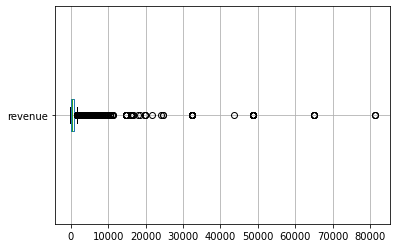

In [ ]:
# Строим "ящик с усами"
orders_df[orders_df['currency_code']=='rub'].boxplot(column='revenue',vert=False)

Видны отчетливые выбросы, которые следует отфильтровать.

In [ ]:
# Выделим покупки за рубли в отдельный датафрейм
rub_df = orders_df[orders_df['currency_code']=='rub'].copy()

# Находим 99-й процентиль
outliers = rub_df['revenue'].quantile(0.99)

# Отбираем данные, оставляя значения меньше найденного порога выбросов
rub_df_new = rub_df.loc[rub_df['revenue'] < outliers]

# Выводим результат describe() после фильтрации данных
print(rub_df_new['revenue'].describe())

count    282922.000000
mean        509.967304
std         500.112654
min         -90.760000
25%         111.660000
50%         340.250000
75%         781.090000
max        2569.590000
Name: revenue, dtype: float64


Теперь таким же образом проверим покупки за тенге.

In [ ]:
# Используем метод describe для нахождения выбросов
orders_df[orders_df['currency_code']=='kzt']['revenue'].describe()

count     5069.000000
mean      4995.206767
std       4916.752776
min          0.000000
25%        518.100000
50%       3698.830000
75%       7397.660000
max      26425.860000
Name: revenue, dtype: float64

По сравнению с рублями, ситуация с тенге обстоит лучше, из аномальных значений только нулевая выручка. Для большей наглядности построим диаграмму размаха.

<AxesSubplot:>

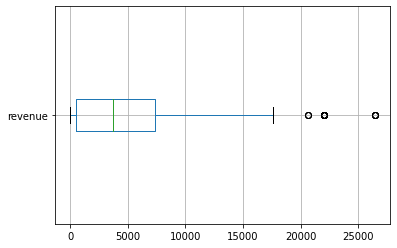

In [ ]:
# Строим "ящик с усами"
orders_df[orders_df['currency_code']=='kzt'].boxplot(column='revenue',vert=False)

На диаграмме видны выбросы, поэтому так же отфильтруем их по 99-му процентилю.

In [ ]:
# Выделим покупки за тенге в отдельный датафрейм
kzt_df = orders_df[orders_df['currency_code']=='kzt'].copy()

# Находим 99-й процентиль
outliers_2 = kzt_df['revenue'].quantile(0.99)

# Отбираем данные, оставляя значения меньше найденного порога выбросов
kzt_df_new = kzt_df.loc[kzt_df['revenue'] < outliers_2]

# Выводим результат describe() после фильтрации данных
print(kzt_df_new['revenue'].describe())

count     4844.000000
mean      4378.842494
std       4072.645224
min          0.000000
25%        486.030000
50%       3698.830000
75%       7076.240000
max      17230.320000
Name: revenue, dtype: float64


Теперь соединим отфильтрованные данные обратно в один датасет.

In [ ]:
# Используем метод merge
new_df = rub_df_new.merge(kzt_df_new,how='outer')

Следует также рассмотреть на предмет выбросов столбец с количеством купленных билетов.

In [ ]:
# Используем метод describe для нахождения выбросов
new_df['tickets_count'].describe(percentiles=[0.99])

count    287766.000000
mean          2.739031
std           1.162231
min           1.000000
50%           3.000000
99%           6.000000
max          57.000000
Name: tickets_count, dtype: float64

Максимальное значение в разы превосходит 99-й процентиль, что может указывать на наличие выбросов. Посмотрим на диаграмму размаха для столбца `tickets_count`:

<AxesSubplot:>

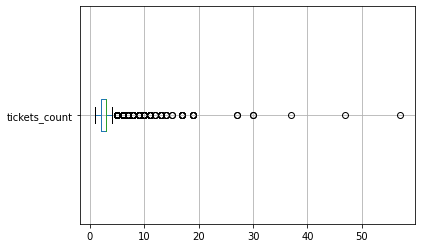

In [ ]:
# Строим "ящик с усами"
new_df.boxplot(column='tickets_count',vert=False)

Так как выбросы могут исказить анализ, следует их удалить.

In [ ]:
# Находим 99-й процентиль
outliers_3 = new_df['tickets_count'].quantile(0.99)

# Отбираем данные, оставляя значения меньше найденного порога выбросов
new_df = new_df.loc[new_df['tickets_count'] < outliers_3]

# Выводим результат describe() после фильтрации данных
print(new_df['tickets_count'].describe())

count    283680.000000
mean          2.689206
std           1.076026
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           5.000000
Name: tickets_count, dtype: float64


Мы избавились от выбросов в данных, теперь можно переходить к следующему этапу предобработки.

### Проверка на явные и неявные дубликаты

Для начала проверим, есть ли в данных явные дубликаты.

In [ ]:
print(f'Количество явных дубликатов в датасете new_df:{new_df.duplicated().sum()}')
print(f'Количество явных дубликатов в датасете events_df:{events_df.duplicated().sum()}')

Количество явных дубликатов в датасете new_df:0
Количество явных дубликатов в датасете events_df:0


Теперь проверим, есть ли неявные дубликаты в бронированиях билета, для этого будем использовать все столбцы, кроме идентификатора заказа.

In [ ]:
# Используем метод duplicated и задаем нужные столбцы
new_df.duplicated(subset=['user_id', 'created_dt_msk','created_ts_msk', 'device_type_canonical','cinema_circuit',
    'age_limit','currency_code','service_name', 'event_id','tickets_count',
    'revenue', 'total']).sum()

38

In [ ]:
# Вычисляем процент дубликатов от общего количества строк
duplicates = (new_df.duplicated(subset=['user_id', 'created_dt_msk','created_ts_msk', 'device_type_canonical','cinema_circuit',
    'age_limit','currency_code','service_name', 'event_id','tickets_count',
    'revenue', 'total']).sum()/new_df.shape[0])
print(f'Процент неявных дубликатов в датасете new_df: {duplicates}')

Процент неявных дубликатов в датасете new_df: 0.00013395375070501974


Мы нашли 38 дубликатов, что составляет менее 0.01% от всего датасета. Так как процент дубликатов низок, их можно просто удалить.

In [ ]:
# Удаляем дубликаты из нужных столбцов
new_df = new_df.drop_duplicates(subset=['user_id', 'created_dt_msk','created_ts_msk', 'device_type_canonical','cinema_circuit',
    'age_limit','currency_code','service_name', 'event_id','tickets_count',
    'revenue', 'total'])

In [ ]:
# Делаем проверку
new_df.duplicated(subset=['user_id', 'created_dt_msk','created_ts_msk', 'device_type_canonical','cinema_circuit',
    'age_limit','currency_code','service_name', 'event_id','tickets_count',
    'revenue', 'total']).sum()

0

Теперь можем перейти к преобразованию типов данных.

### Преобразование типов данных

Для удобства объединим все представленные датасеты в один.

In [ ]:
# Поочередно присоединяем датафреймы
new_plus_events = new_df.merge(events_df, how='inner', on='event_id')
total_df = new_plus_events.merge(tenge_df, how='left',left_on='created_dt_msk',right_on='data')

# И выводим первые строки получившегося общего датасета
total_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,nominal,curs,cdx
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,каменевский регион,глиногорск,213,3972,"сценический центр ""деталь"" групп","алл. машиностроителей, д. 19 стр. 6",2024-08-20,100,18.6972,kzt
1,7431164,024dc5236465850,2024-07-23,2024-07-23 20:52:02,169230,нет,16,rub,mobile,1902.42,...,каменевский регион,глиногорск,213,3972,"сценический центр ""деталь"" групп","алл. машиностроителей, д. 19 стр. 6",2024-07-23,100,18.3419,kzt
2,7431106,024dc5236465850,2024-07-23,2024-07-23 20:54:19,169230,нет,16,rub,mobile,1141.45,...,каменевский регион,глиногорск,213,3972,"сценический центр ""деталь"" групп","алл. машиностроителей, д. 19 стр. 6",2024-07-23,100,18.3419,kzt
3,7431135,024dc5236465850,2024-07-23,2024-07-23 20:59:44,169230,нет,16,rub,mobile,1902.42,...,каменевский регион,глиногорск,213,3972,"сценический центр ""деталь"" групп","алл. машиностроителей, д. 19 стр. 6",2024-07-23,100,18.3419,kzt
4,7431048,024dc5236465850,2024-07-23,2024-07-23 21:02:08,169230,нет,16,rub,mobile,1521.94,...,каменевский регион,глиногорск,213,3972,"сценический центр ""деталь"" групп","алл. машиностроителей, д. 19 стр. 6",2024-07-23,100,18.3419,kzt


Проверим какие столбцы нам нужно изменить:

In [ ]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283405 entries, 0 to 283404
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                283405 non-null  int64  
 1   user_id                 283405 non-null  object 
 2   created_dt_msk          283405 non-null  object 
 3   created_ts_msk          283405 non-null  object 
 4   event_id                283405 non-null  int64  
 5   cinema_circuit          283405 non-null  object 
 6   age_limit               283405 non-null  int64  
 7   currency_code           283405 non-null  object 
 8   device_type_canonical   283405 non-null  object 
 9   revenue                 283405 non-null  float64
 10  service_name            283405 non-null  object 
 11  tickets_count           283405 non-null  int64  
 12  total                   283405 non-null  float64
 13  days_since_prev         262028 non-null  float64
 14  event_name          

In [ ]:
# Приводим тип столбцов с датой и временем к datetime64
total_df['created_dt_msk'] = pd.to_datetime(total_df['created_dt_msk'])
total_df['created_ts_msk'] = pd.to_datetime(total_df['created_ts_msk'])
total_df['data'] = pd.to_datetime(total_df['data'])

# Приводим данные к типу object
total_df['order_id'] = total_df['order_id'].astype(object)
total_df['event_id'] = total_df['event_id'].astype(object)

# Оптимизируем размерность некоторых количественных столбцов
total_df['age_limit'] = pd.to_numeric(total_df['age_limit'], downcast='integer')
total_df['tickets_count'] = pd.to_numeric(total_df['tickets_count'], downcast='integer')
total_df['total'] = pd.to_numeric(total_df['total'], downcast='float')
total_df['city_id'] = pd.to_numeric(total_df['city_id'], downcast='integer')
total_df['venue_id'] = pd.to_numeric(total_df['venue_id'], downcast='integer')
total_df['nominal'] = pd.to_numeric(total_df['nominal'], downcast='integer')
total_df['curs'] = pd.to_numeric(total_df['curs'], downcast='float')

Делаем проверку:

In [ ]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283405 entries, 0 to 283404
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                283405 non-null  object        
 1   user_id                 283405 non-null  object        
 2   created_dt_msk          283405 non-null  datetime64[ns]
 3   created_ts_msk          283405 non-null  datetime64[ns]
 4   event_id                283405 non-null  object        
 5   cinema_circuit          283405 non-null  object        
 6   age_limit               283405 non-null  int8          
 7   currency_code           283405 non-null  object        
 8   device_type_canonical   283405 non-null  object        
 9   revenue                 283405 non-null  float64       
 10  service_name            283405 non-null  object        
 11  tickets_count           283405 non-null  int8          
 12  total                   283405

Таким образом, типы данных были изменены и оптимизированы.

### Создание новых столбцов

Для единообразия данных, переведем выручку в тенге в рубли, создав новый столбец.

In [ ]:
# Пишем функцию для конвертации валюты
def tenge_to_rub(row):
    if row['currency_code'] == row['cdx']:
        return round((row['revenue'] / row['nominal']) * row['curs'],2)
    else:
        return row['revenue']

# Создаем новый столбец и применяем функцию
total_df['revenue_rub'] = total_df.apply(tenge_to_rub, axis=1)

Проверим, что тенге корректно переводятся в рубли:

In [ ]:
total_df[total_df['currency_code']=='kzt'].head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,city_name,city_id,venue_id,venue_name,venue_address,data,nominal,curs,cdx,revenue_rub
47878,2891098,bc49e6b521ea27d,2024-06-09,2024-06-09 15:54:21,42299,нет,12,kzt,mobile,1131.38,...,сарыжар,16,1985,"образовательный центр ""восход"" лимитед","пр. кооперативный, д. 4/6 к. 3/7",2024-06-09,100,19.861799,kzt,224.71
257160,5835787,092ac4bd09618e8,2024-09-25,2024-09-25 12:21:23,546811,нет,0,kzt,mobile,2898.20,...,глиногорск,213,922,"школа живописи для детей ""лебедь"" инк","наб. красноармейская, д. 63 к. 1",2024-09-25,100,19.326200,kzt,560.11
257161,5835816,092ac4bd09618e8,2024-09-25,2024-09-25 10:56:39,546811,нет,0,kzt,mobile,2318.56,...,глиногорск,213,922,"школа живописи для детей ""лебедь"" инк","наб. красноармейская, д. 63 к. 1",2024-09-25,100,19.326200,kzt,448.09
257162,5835758,092ac4bd09618e8,2024-09-25,2024-09-25 12:23:57,546811,нет,0,kzt,mobile,1738.92,...,глиногорск,213,922,"школа живописи для детей ""лебедь"" инк","наб. красноармейская, д. 63 к. 1",2024-09-25,100,19.326200,kzt,336.07
257163,3076321,0beb8fc0c0a9ce1,2024-08-07,2024-08-07 11:06:08,546811,нет,0,kzt,desktop,1738.92,...,глиногорск,213,922,"школа живописи для детей ""лебедь"" инк","наб. красноармейская, д. 63 к. 1",2024-08-07,100,17.848600,kzt,310.37


Теперь создадим новый столбец с выручкой с продажи одного билета.

In [ ]:
# Пишем функцию, находящую стоимость одного билета
def one_ticket_revenue(row):
    return round(row['revenue_rub']/row['tickets_count'],2)
# Создаем новый столбец и применяем функцию
total_df['one_ticket_revenue_rub'] = total_df.apply(one_ticket_revenue,axis=1)

Нам также понадобится столбец с номером месяца даты покупки билета, поэтому создадим его:

In [ ]:
# Создаем новый столбец с номером месяца
total_df['month'] = total_df['created_dt_msk'].dt.month

Добавим столбец, обозначающий сезонность:

In [ ]:
# Пишем функцию, выделяющую сезон года
def seasons(row):
    if row['month'] < 3:
        return 'зима'
    elif row['month'] < 6:
        return 'весна'
    elif row['month'] < 9:
        return 'лето'
    elif row['month'] < 12:
        return 'осень'
    else:
        return 'зима'

# Создаем новый столбец и применяем функцию
total_df['season'] = total_df.apply(seasons, axis=1)

In [ ]:
# Проверяем все добавленные столбцы
total_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,venue_name,venue_address,data,nominal,curs,cdx,revenue_rub,one_ticket_revenue_rub,month,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,"сценический центр ""деталь"" групп","алл. машиностроителей, д. 19 стр. 6",2024-08-20,100,18.697201,kzt,1521.94,380.49,8,лето
1,7431164,024dc5236465850,2024-07-23,2024-07-23 20:52:02,169230,нет,16,rub,mobile,1902.42,...,"сценический центр ""деталь"" групп","алл. машиностроителей, д. 19 стр. 6",2024-07-23,100,18.341900,kzt,1902.42,380.48,7,лето
2,7431106,024dc5236465850,2024-07-23,2024-07-23 20:54:19,169230,нет,16,rub,mobile,1141.45,...,"сценический центр ""деталь"" групп","алл. машиностроителей, д. 19 стр. 6",2024-07-23,100,18.341900,kzt,1141.45,380.48,7,лето
3,7431135,024dc5236465850,2024-07-23,2024-07-23 20:59:44,169230,нет,16,rub,mobile,1902.42,...,"сценический центр ""деталь"" групп","алл. машиностроителей, д. 19 стр. 6",2024-07-23,100,18.341900,kzt,1902.42,380.48,7,лето
4,7431048,024dc5236465850,2024-07-23,2024-07-23 21:02:08,169230,нет,16,rub,mobile,1521.94,...,"сценический центр ""деталь"" групп","алл. машиностроителей, д. 19 стр. 6",2024-07-23,100,18.341900,kzt,1521.94,380.49,7,лето


In [ ]:
# Рассчитаем долю срезанных данных
cut_data = ((orders_df.shape[0]-total_df.shape[0])/orders_df.shape[0])*100
print(f'Процент удаленных данных:{round(cut_data,1)}%')

Процент удаленных данных:2.6%


Таким образом, в результате предобработки нами было отобрано 283405 строк, оставшихся после фильтрации по 99-му процентилю столбцов `revenue` и `tickets_count`, удалены дубликаты, оптимизированны типы данных и создано четыре новых столбца:
- `revenue_rub` - выручка в рублях;
- `one_ticket_revenue_rub` - выручка с продажи одного билета;
- `month` - месяц продажи;
- `season` - сезон.

Предобработка данных закончена, можно приступать к исследовательскому анализу данных.

## Исследовательский анализ данных

### Анализ распределения заказов по сегментам и их сезонные изменения

**Абсолютное количество заказов**

Проверим, увеличилось ли количество заказов с июня по ноябрь.

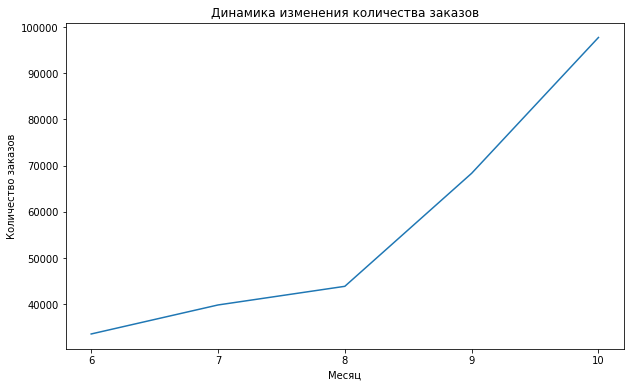

In [ ]:
# Создаем переменную с подсчетом заказов и их группировкой по месяцам
order_count = total_df.groupby('month')['order_id'].count()

# Строим линейный график
plt.figure(figsize=(10,6))
order_count.plot.line(x='month',y='order_id', title='Динамика изменения количества заказов', 
                      xlabel='Месяц', ylabel='Количество заказов',xticks=order_count.index)
plt.show()

На графике виден плавный рост на протяжении всего лета и резкий скачок количества заказов в августе. Это подтверждает присутствие фактора сезонности.

**Сравнение распределения заказов по типу мероприятия**

In [ ]:
# Выделим данные за лето и осень
summer = total_df[total_df['season']=='лето'].copy()
autumn = total_df[total_df['season']=='осень'].copy() 

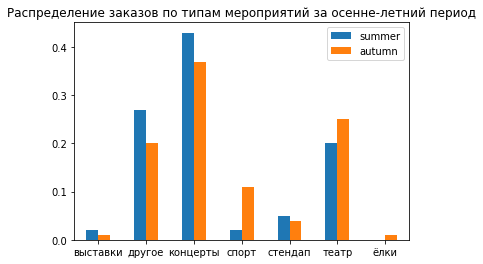

In [ ]:
# Считаем доли типов мероприятий от общего числа заказов
summer_type = round(summer.groupby('event_type_main')['order_id'].count()/summer.shape[0],2)

# Повторяем то же самое для осеннего периода
autumn_type = round(autumn.groupby('event_type_main')['order_id'].count()/autumn.shape[0],2)

types = pd.DataFrame({'summer': summer_type,
    'autumn': autumn_type})
    
# Строим столбчатую диаграмму
types.plot(kind='bar',title='Распределение заказов по типам мероприятий за осенне-летний период', rot=0, xlabel='')
plt.show()

Распределение категорий событий осенью изменилось: 
- Снизилась доля концертов от общего числа мероприятий и доля категории "другое", также незначительно уменьшились доли типов "выставки" и "стендап". Эти изменения могут быть вызваны появившимся интересом к другим типам мероприятий, например, театру. 
- Значительно увеличилась доля спортивных мероприятий  и театра , кроме того, появился небольшой спрос на новогодние ёлки. Рост популярности театра очевиден - начался новый театральный сезон, возможно, в мире спорта существуют такие же сезоны, поэтому доля событий так увеличилась. 

**Сравнение распределения заказов по типу устройства**

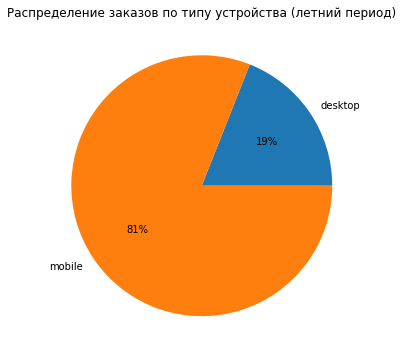

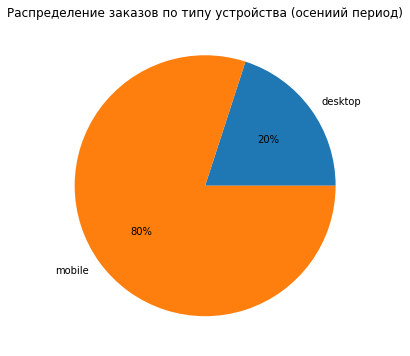

In [ ]:
# Считаем доли типов устройств от общего числа заказов
summer_device = round(summer.groupby('device_type_canonical')['order_id'].count()/summer.shape[0],2)

# Строим круговую диаграмму
plt.figure(figsize=(6,6))
summer_device.plot(kind='pie',ylabel='', autopct='%.0f%%',title='Распределение заказов по типу устройства (летний период)')

plt.show()

# Делаем то же самое для осеннего периода
autumn_device = round(autumn.groupby('device_type_canonical')['order_id'].count()/autumn.shape[0],2)

plt.figure(figsize=(6,6))
autumn_device.plot(kind='pie',ylabel='', autopct='%.0f%%',title='Распределение заказов по типу устройства (осениий период)')

plt.show()

Разница между осенним и летним периодом составляет 1%, что не влияет на общую картину - пользователи предпочитают пользоваться мобильными устройствами.

**Сравнение распределения заказов по категориям возрастного рейтинга**

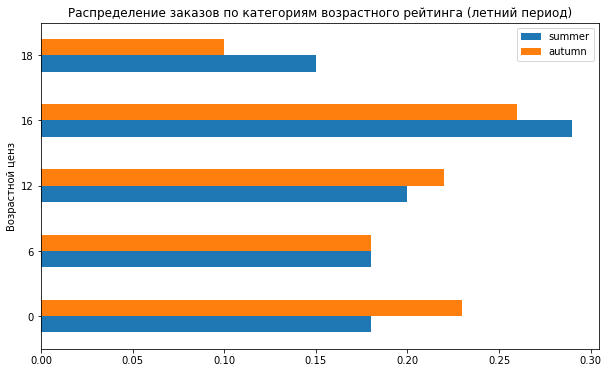

In [ ]:
# Считаем доли категорий возрастного рейтинга от общего числа заказов
summer_age = round((summer.groupby('age_limit')['order_id'].count()/summer.shape[0]).sort_values(),2)

# Делаем то же самое для осеннего периода
autumn_age = round((autumn.groupby('age_limit')['order_id'].count()/autumn.shape[0]).sort_values(),2)

age = pd.DataFrame({'summer': summer_age,
    'autumn': autumn_age})

# Строим столбчатую диаграмму
age.plot(kind='barh',title='Распределение заказов по категориям возрастного рейтинга (летний период)', 
                xlabel='Возрастной ценз',figsize=(10,6))
plt.show()

Самой распространенной категорией мероприятий в не зависимости от сезона являются события 16+. Осенью снизилось доля мероприятий 18+ и 16+ и выросла доля событий 0+. Это может быть связано с ростом популярности спортивных событий, на которых обычно нет ограничений по возрасту, и покупкой билетов на новогодние ёлки. 

**Изменение выручки с продажи одного билета в зависимости от типа мероприятия**

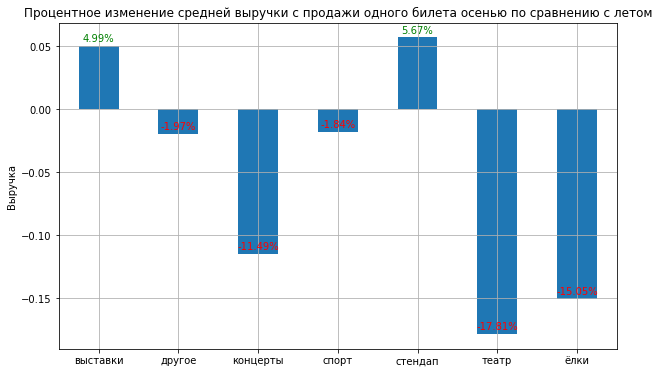

In [ ]:
# Считаем доли категорий возрастного рейтинга от общего числа заказов
summer_one_ticket = summer.groupby('event_type_main')['one_ticket_revenue_rub'].mean()

autumn_one_ticket = autumn.groupby('event_type_main')['one_ticket_revenue_rub'].mean()

# Вычисляем процентную разницу между билетами осенью и летом
one_ticket = (autumn_one_ticket-summer_one_ticket)/summer_one_ticket

# Строим столбчатую диаграмму
one_ticket.plot(kind='bar',
                       title='Процентное изменение средней выручки с продажи одного билета осенью по сравнению с летом',
                       rot=0,xlabel='',ylabel='Выручка',figsize=(10,6),grid=True)
for i, v in enumerate(one_ticket):
    color = 'red' if v < 0 else 'green'
    plt.text(i, v+0.006, f'{v*100:.2f}%',va='center',ha='center', color=color)
    
plt.show()

Видны следующие тенденции в изменении средней выручки с одного билета:
- Значительное снижение выручки произошло в категориях "концерты", "театр","ёлки". Возможно, потому что к последним категориям возрос интерес пользователей и они стали покупать больше билетов, средняя выручка упала.
- Небольшое увеличение выручки наблюдается в категориях "стендап" и "выставки". Здесь может быть обратная ситуация: покупается меньше билетов, поэтому среднее растет.

### Осенняя активность пользователей

**Анализ динамики изменений по дням**

Подготовим данные к визуализации:

In [ ]:
# Создаем сводную таблицу с подсчетом DAU и количества заказов по дням
pivot_user_activity = pd.pivot_table(autumn, index='created_dt_msk', values = ['order_id','user_id'],aggfunc='nunique')
display(pivot_user_activity)

,order_id,user_id
created_dt_msk,,
2024-09-01,1302,559
2024-09-02,1367,570
2024-09-03,4991,770
2024-09-04,1749,677
2024-09-05,1924,733
...,...,...
2024-10-27,2819,1025
2024-10-28,2797,975
2024-10-29,2799,994


In [ ]:
# Создаем переменную с подсчетом количества заказов на одного пользователя
orders_per_user = pivot_user_activity['order_id']/pivot_user_activity['user_id']
display(orders_per_user)

created_dt_msk
2024-09-01    2.329159
2024-09-02    2.398246
2024-09-03    6.481818
2024-09-04    2.583456
2024-09-05    2.624829
                ...   
2024-10-27    2.750244
2024-10-28    2.868718
2024-10-29    2.815895
2024-10-30    2.817025
2024-10-31    4.686709
Length: 61, dtype: float64

In [ ]:
# Создаем сводную таблицу с подсчетом средней стоимости одного билета
pivot_one_ticket = pd.pivot_table(autumn, index='created_dt_msk', values = 'one_ticket_revenue_rub',aggfunc='mean')
display(pivot_one_ticket)

,one_ticket_revenue_rub
created_dt_msk,
2024-09-01,200.713472
2024-09-02,189.860980
2024-09-03,80.838866
2024-09-04,178.318902
2024-09-05,189.977853
...,...
2024-10-27,187.365534
2024-10-28,171.682946
2024-10-29,178.493666


Визуализируем каждую метрику отдельно:

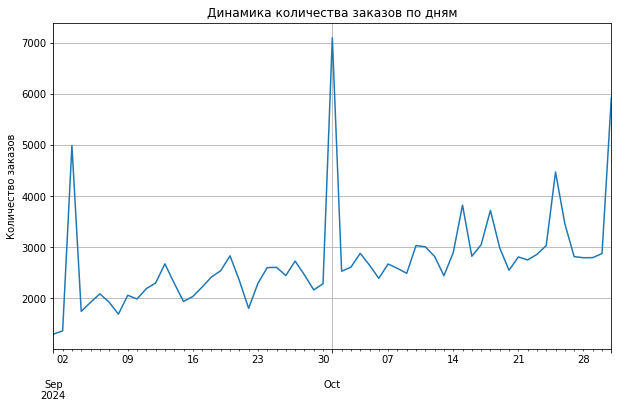

In [ ]:
# Строим линейную диаграмму для количества заказов
plt.figure(figsize=(10,6))
pivot_user_activity['order_id'].plot.line(x='created_dt_msk', 
                                          title='Динамика количества заказов по дням',
                                          xlabel='',
                                          ylabel='Количество заказов',
                                         grid=True)
plt.show()

Метрика количества заказов нестабильна - видны резкие пики в начале сентября и октября, а также в конце октября. Возможно, такой сильный перепад значений вызван открытием продажи билетов на ожидаемые мероприятия или выплатой зарплаты в эти дни.

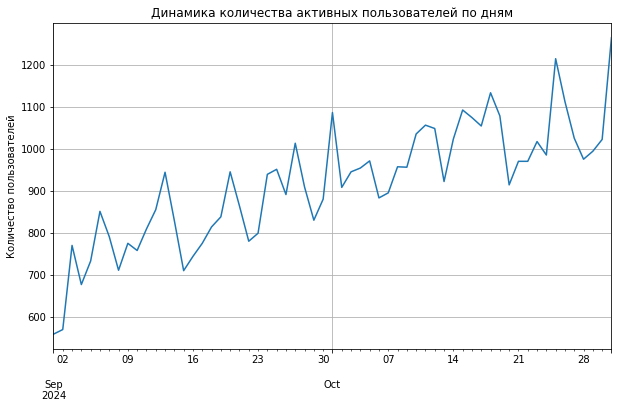

In [ ]:
# Строим линейную диаграмму для количества пользователей
plt.figure(figsize=(10,6))
pivot_user_activity['user_id'].plot.line(x='created_dt_msk', 
                                          title='Динамика количества активных пользователей по дням',
                                          xlabel='',
                                          ylabel='Количество пользователей',
                                        grid=True)
plt.show()

Метрика количества активных пользователей за день так же нестабильна, но виден явный положительный тренд роста. 

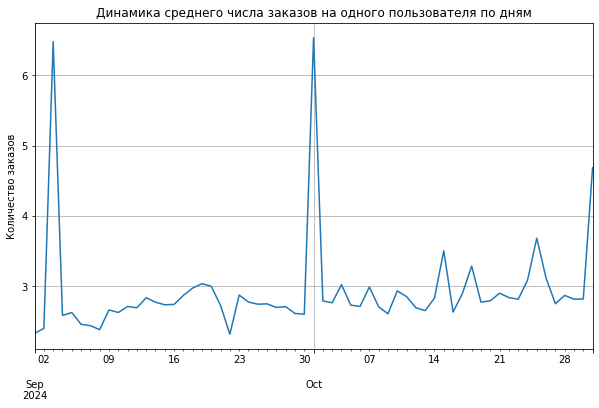

In [ ]:
# Строим линейную диаграмму для среднего числа заказов на пользователя
plt.figure(figsize=(10,6))
orders_per_user.plot.line(x='created_dt_msk', 
                                          title='Динамика среднего числа заказов на одного пользователя по дням',
                                          xlabel='',
                                          ylabel='Количество заказов',
                                        grid=True)
plt.show()

Метрика среднего числа заказов на одного пользователя по дням перекликается с метрикой общего числа заказов - пики отмечаются в одни и те же дни. 

<Figure size 720x432 with 0 Axes>

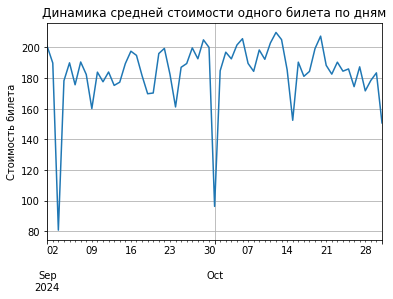

In [ ]:
# Строим линейную диаграмму для средней стоимости билета
plt.figure(figsize=(10,6))
pivot_one_ticket.plot.line(title='Динамика средней стоимости одного билета по дням',
                                          xlabel='',
                                          ylabel='Стоимость билета',
                                         grid=True,
                          legend=False)
plt.show()

Динамика средней стоимости одного билета зеркальна динамике количества заказов, это может говорить о том, что в даты пиков проходили большие скидки, из-за чего количество заказов возросло,а средняя стоимость билета снизилась.

Осенью 2024 года наблюдается положительная динамика: общее число заказов и количество активных пользователей постепенно увеличиваются. Среднее число заказов на одного пользователя остаётся стабильным, с пиками в отдельные дни. Средняя стоимость билета колеблется, но не демонстрирует чёткой тенденции.

**Анализ недельной цикличности**

In [ ]:
# Создаем новый столбец с названием дня недели
autumn.loc[:, 'day_of_week'] = autumn['created_dt_msk'].dt.day_name()

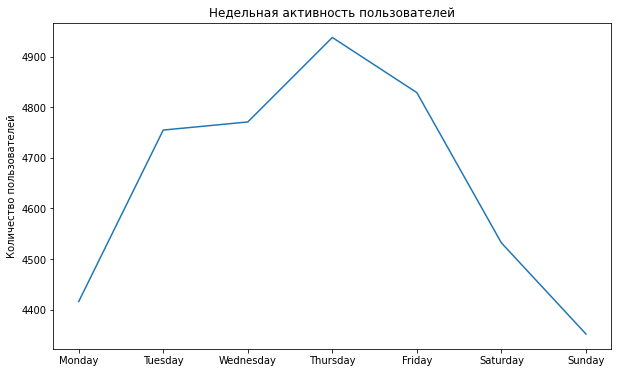

In [ ]:
# Создаем таблицу для расчета количества пользователей на день недели
week_user_activity = pd.pivot_table(autumn, index='day_of_week', values='user_id', aggfunc='nunique')

# Задаем порядок дней недели
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
week_user_activity.index = pd.CategoricalIndex(week_user_activity.index, categories=days_order, ordered=True)

# Строим линейную диаграмму
week_user_activity.sort_index().plot.line(title='Недельная активность пользователей',
                                         legend=False, xlabel='',
                                         ylabel='Количество пользователей',figsize=(10,6))

plt.show()

Самые высокие показатели активности демонстрируют четверг и пятница - более 4800 человек. Самые низкие - воскресенье и понедельник, около 4400 человек.

Таким образом, метрики количества заказов и активных пользователей показывают нестабильность с заметными пиками в начале и конце октября, что может быть связано с открытием продажи билетов или скидками. В то же время, наблюдается положительный тренд роста активных пользователей. Наибольшая активность наблюдается в четверг и пятницу, а минимальная — в понедельник и выходные дни.

### Популярные события и партнёры

Рассмотрим какие регионы являются лидерами в разрезе уникальных мероприятий и количества бронирования билетов, а также выясним, как в целом распределены данные по территориальным единицам.

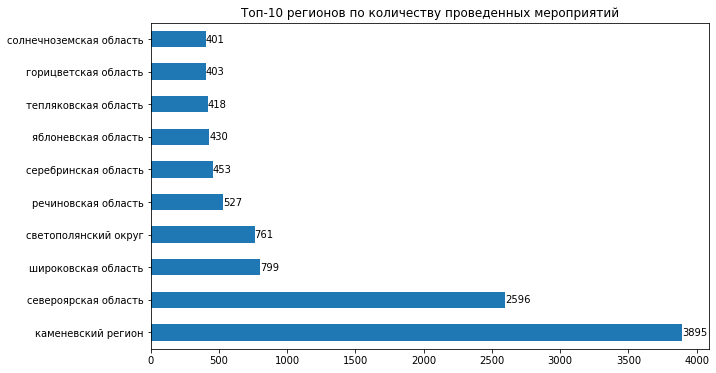

In [ ]:
# Посчитаем сколько уникальных мероприятий в абсолютных количествах проводят регионы
reg_type_count = autumn.groupby('region_name')['event_id'].nunique().sort_values(ascending=False).head(10)

# Строим столбчатую диаграмму
reg_type_count.plot(kind='barh',xlabel='',ylabel='Количество мероприятий',rot=0,
                    figsize=(10,6),title='Топ-10 регионов по количеству проведенных мероприятий')

# Добавляем подписи значений у столбцов
for i, v in enumerate(reg_type_count):
    plt.text(v, i, str(v), va='center', ha='left')
    
plt.show()

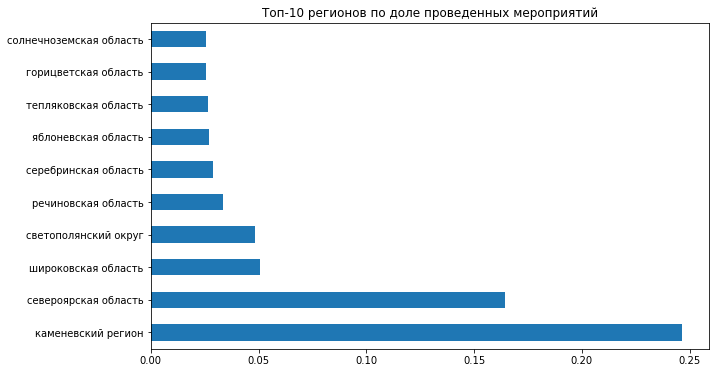

In [ ]:
# Выделим долю от общего количества мероприятий для каждого региона
reg_type_share = (autumn.groupby('region_name')['event_id'].nunique()/
                  autumn['event_id'].nunique()).sort_values(ascending=False).head(10)
# Строим столбчатую диаграмму
reg_type_share.plot(kind='barh',xlabel='',ylabel='Доля проведенных мероприятий',rot=0,
                    figsize=(10,6),title='Топ-10 регионов по доле проведенных мероприятий')
plt.show()

Больше всего мероприятий проводят два региона - Каменевский регион и Североярская область, их общая доля составляет более 40%.

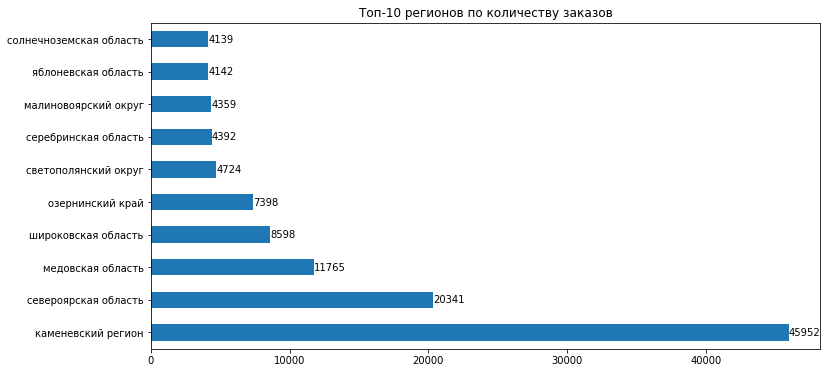

In [ ]:
# Посчитаем общее количество заказов по регионам
reg_order_count = autumn.groupby('region_name')['order_id'].nunique().sort_values(ascending=False).head(10)

# Строим столбчатую диаграмму
reg_order_count.plot(kind='barh',xlabel='',ylabel='Количество заказов',rot=0,
                    figsize=(12,6),title='Топ-10 регионов по количеству заказов')

# Добавляем подписи значений у столбцов
for i, v in enumerate(reg_order_count):
    plt.text(v, i, str(v), va='center', ha='left')
    
plt.show()

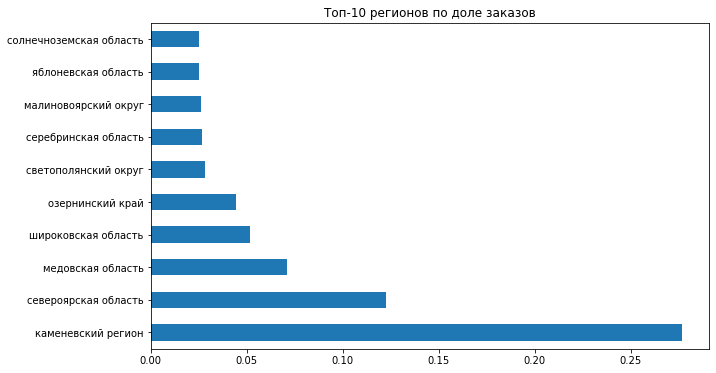

In [ ]:
# Выделим доли от общего количества заказов в регионах
reg_order_share = (autumn.groupby('region_name')['order_id'].nunique()/autumn['order_id']
                   .nunique()).sort_values(ascending=False).head(10)

# Строим столбчатую диаграмму
reg_order_share.plot(kind='barh',xlabel='',ylabel='Количество заказов',rot=0,
                    figsize=(10,6),title='Топ-10 регионов по доле заказов')
    
plt.show()

Каменевский регион и Североярская область остаются лидерами и в разрезе количества заказов. При этом в топе появляются Медовская, Широковская области и Озернинский край, которые не отличались большим количеством проведенных мероприятий. Возможно, хотя эти регионы проводят меньше мероприятий, они являются более масштабными, поэтому и билетов на них продается больше.

Теперь найдем лидеров среди билетных партнеров:

In [ ]:
pd.options.display.float_format ='{:,.0f}'.format

# Группируем данные по названию билетного оператора и сортируем по сумме выручки
autumn.groupby('service_name').agg({'event_id': 'nunique','order_id': 'nunique',
                                    'revenue_rub': 'sum'}).sort_values(by='revenue_rub',ascending=False).head()

,event_id,order_id,revenue_rub
service_name,,,
билеты без проблем,2830,31823,"11,755,085"
мой билет,997,19166,"10,581,845"
облачко,1401,15342,"10,427,507"
лови билет!,3599,25400,"10,100,592"
весь в билетах,596,9290,"9,121,520"


Так как для бизнеса самым главным показателем является выручка, то сортировку мы проводили именно по ней. Из таблицы видно, что лидирующую позицию занимает оператор "Билеты без проблем" с выручкой более 11 млн. При этом видно, что при не таком большом отличии суммы выручки (1.2 млн), количество мероприятий проведенных оператором "Билеты без проблем" и "Мой билет" отличаются почти в 3 раза - 997 против 2830. Может быть, "Мой билет" предлагает более дорогостоящие мероприятия или пользователи предпочитают покупать у данного оператора несколько билетов сразу.

Таким образом, Каменевский регион и Североярская область лидируют по количеству мероприятий и заказов, при этом некоторые регионы с меньшим числом мероприятий могут проводить события с большим объемом продаж. В разрезе суммарной выручки лидирует оператор "Билеты без проблем".

## Статистический анализ данных

До проведения статистических тестов, следует изучить исследуемые группы и проверить,являются ли они сопоставляемыми.

### Наличие одинаковых пользователей

In [ ]:
# Создаем отдельные датафреймы для каждого устройства
mobile = autumn[autumn['device_type_canonical']=='mobile']
desktop = autumn[autumn['device_type_canonical']=='desktop']

# Делим пользователей на группы
mobile_group = mobile['user_id']
desktop_group = desktop['user_id']

# Смотрим, есть ли повторяющиеся пользователи
intersection = list(set(mobile_group) & set(desktop_group))
len(intersection)

3216

In [ ]:
# Удаляем дублирующихся пользователей
autumn_cleared = autumn[~autumn['user_id'].isin(intersection)]

### Размер групп

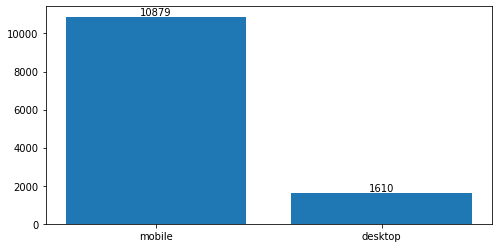

In [ ]:
# Считаем количество пользователей в каждой группе
mobile_count = autumn_cleared[autumn_cleared['device_type_canonical']=='mobile']['user_id'].nunique()
desktop_count = autumn_cleared[autumn_cleared['device_type_canonical']=='desktop']['user_id'].nunique()

# Подготавливаем данные для графика
groups = ['mobile', 'desktop']
counts = [mobile_count, desktop_count]

# Создаем фигуру
plt.figure(figsize=(8, 4))

# Подписываем значения на графике
for i, v in enumerate(counts):
    plt.text(i, v, str(v), ha='center', va='bottom')
    
# Строим столбчатую диаграмму 
plt.bar(groups, counts)
plt.show()

Из графика видно, что количество пользователей мобильных устройств более чем в 6 раз превышает количество пользователей стационарных устройств.

### Распределение групп

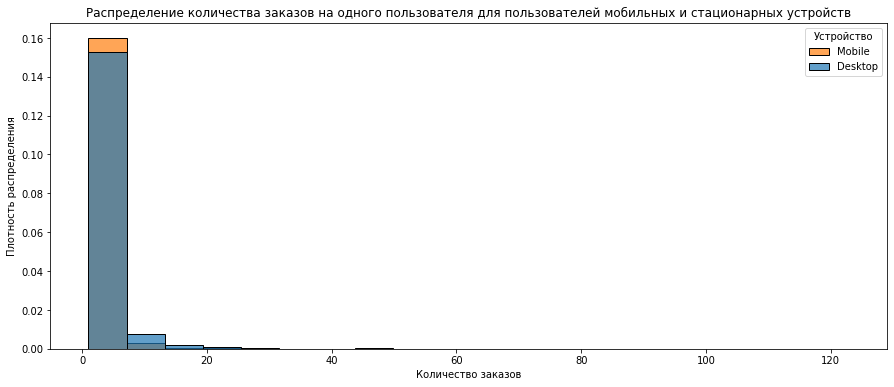

In [ ]:
# Выделяем группы
mobile_p = autumn_cleared[autumn_cleared['device_type_canonical']=='mobile']
desktop_c = autumn_cleared[autumn_cleared['device_type_canonical']=='desktop']

# Создаем общий датафрейм с заказами
orders = pd.DataFrame({'mobile': mobile_p.groupby('user_id')['order_id'].count(),
    'desktop': desktop_c.groupby('user_id')['order_id'].count()})

# Строим гистограмму 
plt.figure(figsize=(15, 6))
sns.histplot(data=orders, bins=20, stat='density', common_norm=False, alpha=0.7)
plt.title('Распределение количества заказов на одного пользователя для пользователей мобильных и стационарных устройств')
plt.xlabel('Количество заказов')
plt.ylabel('Плотность распределения')
plt.legend(title='Устройство', labels=['Mobile', 'Desktop'])
plt.show()

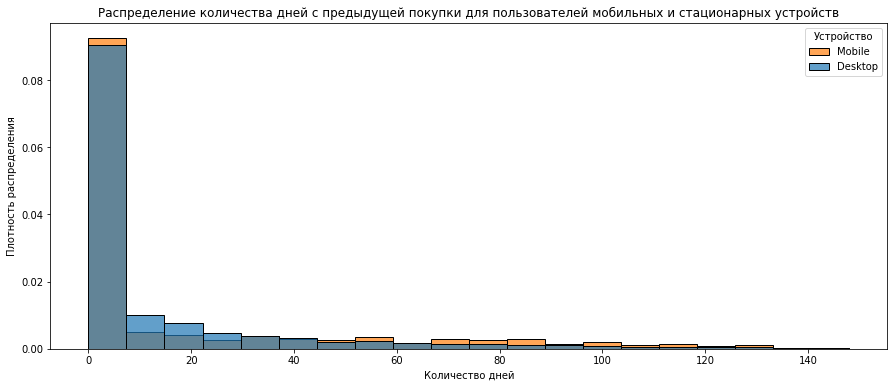

In [ ]:
# Создаем общий датафрейм со временем с момента прошлой покупки
days = pd.DataFrame({'mobile': mobile_p['days_since_prev'],
    'desktop': desktop_c['days_since_prev']})

# Строим гистограмму 
plt.figure(figsize=(15, 6))
sns.histplot(data=days, bins=20, multiple="stack", stat='density', common_norm=False,alpha=0.7)
plt.title('Распределение количества дней с предыдущей покупки для пользователей мобильных и стационарных устройств')
plt.xlabel('Количество дней')
plt.ylabel('Плотность распределения')
plt.legend(title='Устройство', labels=['Mobile', 'Desktop'])
plt.show()

В обеих группах видны тяжелые правые "хвосты", что указывает на выбросы в данных. Так как группы неравны и имеют выбросы, имеет смысл использовать тест Манна-Уитни.

### Проведение статистических тестов

Сформулируем нулевую и альтернативную гипотезы для **среднего количества заказов**:
- Среднее количество заказов в группе A не больше, чем в группе B

$H_0:p_A\leq p_B$
- Среднее количество заказов в группе A больше, чем в группе B

$H_1:p_A>p_B$

In [ ]:
# Разделение данных на группы
group_a = mobile_p  
group_b = desktop_c 

# Расчет среднего количества заказов на одного пользователя
mean_orders_a = group_a.groupby('user_id')['order_id'].nunique().count()
mean_orders_b = group_b.groupby('user_id')['order_id'].nunique().count()

# Проведение U-теста Манна-Уитни для количества заказов
alpha = 0.05
u_stat, p_value = mannwhitneyu(
    group_a.groupby('user_id')['order_id'].nunique(),
    group_b.groupby('user_id')['order_id'].nunique(),
    alternative='greater'
)

# Выводим результат и интерпретацию
if p_value > alpha:
    print(f'Среднее количество заказов на одного пользователя в группе А:{mean_orders_a}')
    print(f'Среднее количество заказов на одного пользователя в группе В:{mean_orders_b}')
    print(f'pvalue={p_value}')
    print('Нулевая гипотеза находит подтверждение. Среднее количество заказов в группе A не больше, чем в группе B.')
else:
    print(f'Среднее количество заказов на одного пользователя в группе А:{mean_orders_a}')
    print(f'Среднее количество заказов на одного пользователя в группе В:{mean_orders_b}')
    print(f'pvalue={p_value}')
    print('Нулевая гипотеза не находит подтверждения. Среднее количество заказов в группе A больше, чем в группе B.')

Среднее количество заказов на одного пользователя в группе А:10879
Среднее количество заказов на одного пользователя в группе В:1610
pvalue=5.3862737942764444e-39
Нулевая гипотеза не находит подтверждения. Среднее количество заказов в группе A больше, чем в группе B.


Сформулируем нулевую и альтернативную гипотезы для **среднего времени между заказами**:
- Среднее время между заказами в группе A не больше, чем в группе B

$H_0:p_A\leq p_B$
- Среднее время между заказами в группе A больше, чем в группе B

$H_1:p_A>p_B$

In [ ]:
# Удаляем пропуски в столбце с днями, прошедшими с последней покупки
mobile_clean = mobile_p.copy()
mobile_clean.dropna(subset=['days_since_prev'], inplace=True)
desktop_clean = desktop_c.copy()
desktop_clean.dropna(subset=['days_since_prev'], inplace=True)

In [ ]:
# Разделение данных на группы
group_1 = mobile_clean  
group_2 = desktop_clean 

# Расчет среднего времени между заказами на одного пользователя
mobile_grouped = np.asarray(mobile_clean.groupby('user_id')['days_since_prev'].mean(), dtype=float)
desktop_grouped = np.asarray(desktop_clean.groupby('user_id')['days_since_prev'].mean(), dtype=float)

# Проведение U-теста Манна-Уитни для среднего времени
alpha = 0.05
ut_stat, p_value_u = mannwhitneyu(
    mobile_grouped,
    desktop_grouped,
    alternative='greater'
)

# Выводим результат и интерпретацию
if p_value_u > alpha:
    print(f'pvalue={p_value_u}')
    print('Нулевая гипотеза находит подтверждение. Среднее время между заказами в группе A не больше, чем в группе B.')
else:
    print(f'pvalue={p_value_u}')
    print('Нулевая гипотеза не находит подтверждения. Среднее время между заказами в группе A больше, чем в группе B.')

pvalue=0.794650898563293
Нулевая гипотеза находит подтверждение. Среднее время между заказами в группе A не больше, чем в группе B.


Таким образом, первая гипотеза о том, что среднее количество заказов на одного пользователя мобильного приложения выше, чем на одного пользователя стационарных устройств подтвердилась,а вторая гипотеза о том, что среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств была опровергнута. 

Это может означать, что пользователи мобильного приложения в целом более активны: совершают больше заказов, чем пользователи сайта, и делают это не реже. 

## Общий вывод и рекомендации

### Информация о данных

Для исследования были предоставлены данные о бронировании билетов на сервисе Яндекс Афиша за период с июня по конец октября. В двух датасетах содержались сведения о заказах билетов с мобильных и станционарных устройств, а также полная информация о проведенных мероприятиях.

В обоих датасетах, предоставленных для исследования, содержались следующие данные:
- уникальные идентификаторы заказа, пользователя и мероприятия;
- дата и время создания заказа;
- категориальные данные: возрастное ограничение, тип устройства, валюта, сеть кинотеатров;
- количественные данные: выручка, количество купленных билетов, общая сумма заказа;
- город,регион события, информация о площадке проведения мероприятия, организаторе и билетном операторе.

Была выполнена предобработка данных, в результате которой нами было отобрано 283405 строк, удалены дубликаты, оптимизированны типы данных и создано четыре новых столбца (выручка в российских рублях, выручка с одного билета, месяц оформления заказа, сезон оформления заказа).

### Результаты анализа

- В осенний период снизилась доля концертов и категории "другое" среди всех проведенных мероприятий, увеличилась популярность спортивных мероприятий и театра, а также появился спрос на новогодние ёлки. При этом, самой популярной категорией событий остаются концерты.
- В возрастных категориях наблюдается снижение доли мероприятий 18+ и 16+, при этом виден рост доли событий 0+, что может быть связано с большей популярностью спортивных и новогодних мероприятий.
- Средняя выручка с одного билета снизилась в категориях "концерты", "театр" и "ёлки", что вероятно связано с покупкой большего количества билетов, при этом в категориях "стендап" и "выставки" средняя выручка выросла.
- Наибольшая пользовательская активность наблюдается в четверг и пятницу, а минимальная — в понедельник и выходные дни.
- Самыми популярными регионами в разрезе мероприятий стали Каменевский регион и Североярская область.
- В разрезе суммарной выручки лидирует оператор "Билеты без проблем", но проигрывает по доле мероприятий.

### Результаты проверки гипотез

Проведенные U-тесты Манна-Уитни подтвердили гипотезу о том, что среднее количество заказов на одного пользователя мобильного приложения выше, чем на одного пользователя стационарных устройств, и опровергли гипотезу о том, что среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

Это может свидетельствовать о том, что пользователи мобильного приложения в целом проявляют более высокий уровень активности по сравнению с пользователями десктопной версии сайта. Они совершают больше заказов за один и тот же период времени, а также делают это с большей частотой, что может указывать на предпочтения пользователей об удобстве использования приложения и быстрой скорости бронирования билетов.

### Рекомендации

- Продолжать развивать мобильное приложение, делая его более интуитивно понятным.
- Закупать больше таргетированной рекламы, предлагать релевантные мероприятия зарегистрированным пользователям по четвергам и пятницам, в разгар пользовательской активности.
- Упростить насколько это возможно интерфейс сайта для стационарных устройств, в особенности страницу выбора места и оплаты билета. 